# Identifiability test
In this noted book we investogate a 'cutting corners calculation' of the main aim of the research. We will determine the the quantity: $$\Delta \chi^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos, $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos and $Cov^{-1}\left[C_{l}^{1}\right]$ is the inverse of the Gaussian covariance. We will build this up simple and possibly explore more complicated renditions later on.

The idea is to calculate this quantity for multiple cosmologies with different neutrino properties given by $C_{l}^{2}$, compared to the $\Lambda CDM$ cosmology, containing only massless neutrinos. More specifically, we will look at the sensitivity in the auto correlation and cross-correlations of the cCMB lensing tracer with the existing tracers used in the 6x2pt. analysis.
These added correlations/angular power spectra, will make up a total 10x2pt. analysis. The goal of this reearch is to develope a forecasting of this analysis.

$\Delta \chi^{2}$ will give us a measure of the sesitivity of the angular power spectra to the neutrino paramters. This in essence could function as a forecast on the neutrino parameter constraining power of the extended analysis. We can relate the value of $\Delta \chi^{2}$ in a cutting corners way to the p-value $\todo{find anything on this p-value}$ which can give us a measure of the sensitivity:

$$\Delta \chi^{2} \sim p \begin{cases}
\ll 1, & \text{(significant) sensitivity}.\\
\sim 1, & \text{if there is no sensitivity}
\end{cases}
$$

and will thus allow us to say something about the potential of the extension of the 6x2pt, analysis by inclusion of the angular power spectra of the CMB lensing tracer. 

Another goal of this is simply the exploration of these processes, to whitness what is going on behind the scenes of the bigger cosmological piplines like cosmoSIS and firecrown.

----

This calculation has a few important elements that we take under the loop one by one.
We will start with defining the cosmologies that we want to investigate. It is these cosmologies that the angular power spectra will be calculated from.
Since we are concerned with the CMB spectra, we must also be concerned with the binning of the redshift space in between current day and last scattering. The accuracy of the analysis also depends on the binning and the properties of the binning process which we will investigate aswell.

The next element is the Gaussian covariance. In the most general case, the Gaussian covariance is a matrix containing the (co)variance between all angular power spectra in (different) bins.
We will start off simple and define a Gaussian covariance for auto correlated bins, such that the Gaussian covariance is diagonal. Later on, we can explore the complexities of the Gaussian covariance and build up the general case.

With these elements in order, we can perform the simplest version of the identifiability test and get an idea of the bigger picture in a small reduces setting.


An important note to make is that this quantitative test is purely based on the singled-out-effect ogf the neutrino parameters on the angular power spectra. As we know, the effects of the cosmological parameters on the matter power spectrum and therefore the angular power spectra are not unique, as we have seen in the previous notebooks:
- [notebook #1](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_P_k.ipynb)
- [notebook #2](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_C_l.ipynb)

This brief analysis in which we cut corners, does not take one of the biggest motivations for this research into account: namely that the inclusion of the CMB lensing angular power spectra can break the degenereacies between these parameters, allowing for an increased constraint on certain parameters after the breaking of these degeneracies.

In [2]:
# The required imports:

import numpy as np
import pyccl as ccl
import pylab as plt
import math
import glass.observations
%matplotlib inline


## Cosmologies
First of all we define the different neutrino based cosmologies.

The neutrino parameters to which cosmology is sensitive, and theoretically/phenomenologically the CMB should be sensitive to are:
- The total sum of neutrino masses, $\sum_{i} m_{\nu, i}$
- The effective number of active neutrino species, $N_{eff}$. In different words, the number of massive/massless neutrinos.

The different cosmologies we define below will mainly be based on these paramters and relative variations on these.


In [3]:
# We define the cosmology:
lcdm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044)

# Alternate neutrino cosmologies:
neutrino_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='normal')
zero_mm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=[0, 0.06, 0.06])
single_nu_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='single')

# The specifics of the angular power spectra:
l = np.linspace(1, 1000, 1000) # multipole moments; ensure that these are 1 to 1 such that the multipole binninb can be done well later on
z = np.linspace(0., 3.0, 1000) # redshifts
a = (1./(1+z))[::-1]

# Biases:
bias = 0.95/ccl.growth_factor(lcdm_cosmo, a) # bias
bias_neutrino = 0.95/ccl.growth_factor(neutrino_cosmo, a)
bias_zero_mm = 0.95/ccl.growth_factor(zero_mm_cosmo, a)
bias_single_nu = 0.95/ccl.growth_factor(single_nu_cosmo, a)

m_bias = np.ones_like(z) # Magnification bias
i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

# Binning:
Define the spectroscopic and photometric bins in which we will specify our angular power spectra.
There are some different practices of binning, for different applications. Here we start with the tomographic redshift binning. This subdivides the redshift space and is done through the use of [glass.observations](https://glass.readthedocs.io/v2023.6/reference/observations.html#rd48878c677a1-1).

We keep in mind that the spectroscopic redshift binning is much more accurate than the photometric redshift binning, shown below. For weak lensing there are some intricacies, namely that the configuration of source and lensing bins must have a certain orientation. This is to be kept in mind with the cross correlations of bins. For the last of the 4 probes, CMB lensing, there is really one bin covering the entire evolution history of the CMB. Since we observe the CMB only at the limit of or possibilities: z = 1100, there is nog redshift contamination. The only thing to keep in mind is the source-lense confguration of bins but this will hardly be relevant for us as we do not consider lensing galaxies beyond z = 1100. (Note that this is physically also not possible since galaxy formation happened in between z = 1100 and z = 0) 

For the other case of binning, we refer to the later part of the notebook, where we bin the angular power spectra ánd the Gaussian covariance. The binning procedure in that case is more intricate and will be touched upon later. The reason for the binning of the angular power spectra and Gaussian covariance can however be disclosed already:
- decreasing the computational cost
- reducing the correlations between the multipoles which is induced by masking in the survey.

But more on this later.

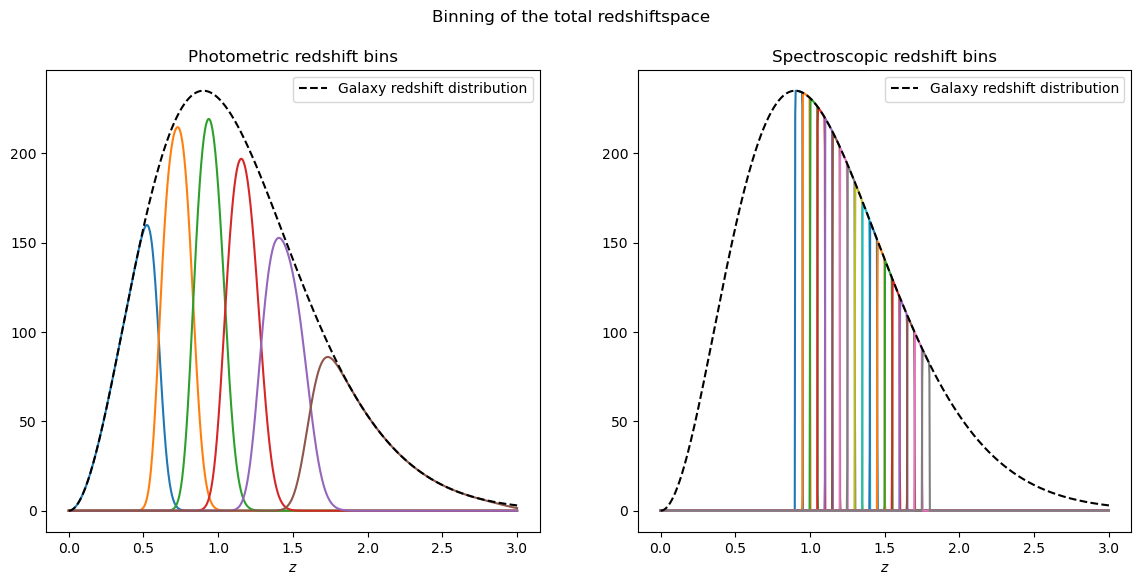

In [4]:
# We define the photometric and spectra through the following:

# Photometric:
# From Euclis we find n_bar = 30 per arcmin**2
n_bar = 300 # Assume a galaxy density and accompanying reshift distribution:
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_bar
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=6)
phot_tomo_bins = glass.observations.tomo_nz_gausserr(z, dndz, 0.03, zbins) # Where the bin error is 0.03

# Spectroscopic:
spec_z = (np.heaviside((z - 0.9), 1) - np.heaviside((z - 1.8), 1)) * dndz
spec_zbins = glass.observations.fixed_zbins(zmin=0.9, zmax=1.8, dz=0.05)
spec_tomo_bins = glass.observations.tomo_nz_gausserr(z, spec_z, 0.0003, spec_zbins)

# We now visualize the redshift binning:
fig, axes = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)
plt.suptitle("Binning of the total redshiftspace")

# Show the photometric bins in a plot:
axes[0].set_title("Photometric redshift bins")
for i in range(len(phot_tomo_bins)):
    axes[0].plot(z, phot_tomo_bins[i])
axes[0].plot(z, dndz, 'k--', label='Galaxy redshift distribution')
axes[0].legend()
axes[0].set_xlabel("$z$")

# Show the spectroscopic bins in a plot:
axes[1].set_title("Spectroscopic redshift bins")
for i in range(len(spec_tomo_bins)):
    axes[1].plot(z, spec_tomo_bins[i])
axes[1].plot(z, dndz, 'k--', label='Galaxy redshift distribution')
axes[1].legend()
axes[1].set_xlabel("$z$")
plt.show()

### Defining the tracers:
Here we define the tracers from which we are building up the angular power spectra. We will need to define these for each of our cosmologies. We will be defining:
- Galaxy clustering (NumberCountsTracer)
    - photometric
    - spectroscopic
    Differentiated by the binning
- Weak lensing (WeakLensingTracer)
    
    Using the photometric bins, since we obderve the source galaxies and their distortions photometrically.
- Cosmic Microwave Background lensing (CMBLensingTracer)
    
    This tracer is based on the CMB surface at a single redshift; z_source=1100, the redshift of last scattering, so we don't ahve to sub-divide the redshift domain

We define the tracer in each of the corresponding bins, such that we build up a dictionary for each of the tracers containing the tracer in each bin.


In [5]:
# LCDM: define the tracers for the vanilla LCDM cosmologocal model:
lcdm_photo_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
lcdm_spec_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
lcdm_wl = {i: ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
lcdm_cmb_l = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100., n_samples=100)

# 3 massive neutrinos cosmology:
neutrino_photo_clus = {i: ccl.NumberCountsTracer(neutrino_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_neutrino), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
neutrino_spec_clus = {i: ccl.NumberCountsTracer(neutrino_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_neutrino), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
neutrino_wl = {i: ccl.WeakLensingTracer(neutrino_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
neutrino_cmb_l = ccl.CMBLensingTracer(neutrino_cosmo, z_source=1100., n_samples=100)

# Tracers for which the cosmological model has a massless lightest neutrino and 2 equally massive neutrino species:
zero_mm_photo_clus = {i: ccl.NumberCountsTracer(zero_mm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_zero_mm), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
zero_mm_spec_clus = {i: ccl.NumberCountsTracer(zero_mm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_zero_mm), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
zero_mm_wl = {i: ccl.WeakLensingTracer(zero_mm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_l = ccl.CMBLensingTracer(zero_mm_cosmo, z_source=1100., n_samples=100)

# For a cosmology of 1 massive and 2 massless neutrino species:
single_photo_clus = {i: ccl.NumberCountsTracer(single_nu_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias_single_nu), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
single_spec_clus = {i: ccl.NumberCountsTracer(single_nu_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias_single_nu), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
single_wl = {i: ccl.WeakLensingTracer(single_nu_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
single_cmb_l = ccl.CMBLensingTracer(single_nu_cosmo, z_source=1100., n_samples=100)

print(lcdm_wl[0], '\n', neutrino_wl[0], '\n', zero_mm_wl[0], '\n', single_wl[0])

<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x199dcfd685c40d8d         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xf01d61b4a9e97f31         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xa5c611091541657f         None           2       -1    
 <pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0x8193ca4ef2274cc9         None           2       -1   


### Angular power spectra of interest
With the tracers we defined above, we can nof set up the angular power spectra we are interested in. Look at the auto and cross corrlations of the CMB lensing tracer. These effectively are the correlations that extend the 6x2pt. analysis to the 10x2pt analysis:
- $\kappa$ x $\kappa $
- $\kappa$ x $\gamma^{\epsilon}$
- $\kappa$ x $\delta_{g}^{p}$
- $\kappa$ x $\delta_{g}^{s}$

#### $\Lambda CDM$ cosmology:
Define the angular power spectra of the auto-correlated and cross-correlated tracers of the $\Lambda CDM$ cosmology:

Note: we evaluate all the angular power spectra in each of the tomorgaphic bins we defined. This gives us: 
- extra layer of cross correlations, if we cross-correlate different bins of drifferent tracers
- the possibility to evaluate each bin over all multipoles(l);
    This is essential because we want to evaluate the angular power spectra on all scales in each of the specific bins that govern our redshift slices.


**Correct the noise types:**
- photometric GC and WL have similar nbar
- Spectroscopic has a different nbar

**Nbar should be in steradian; the dimensionless unit of solid angle. 30 galx arcmin^-2 corresponds to 0.3 gal per bin per arcmin^-2; then multiply by 60^2 for degrees, followed by (pi/180)^2 for steradian**

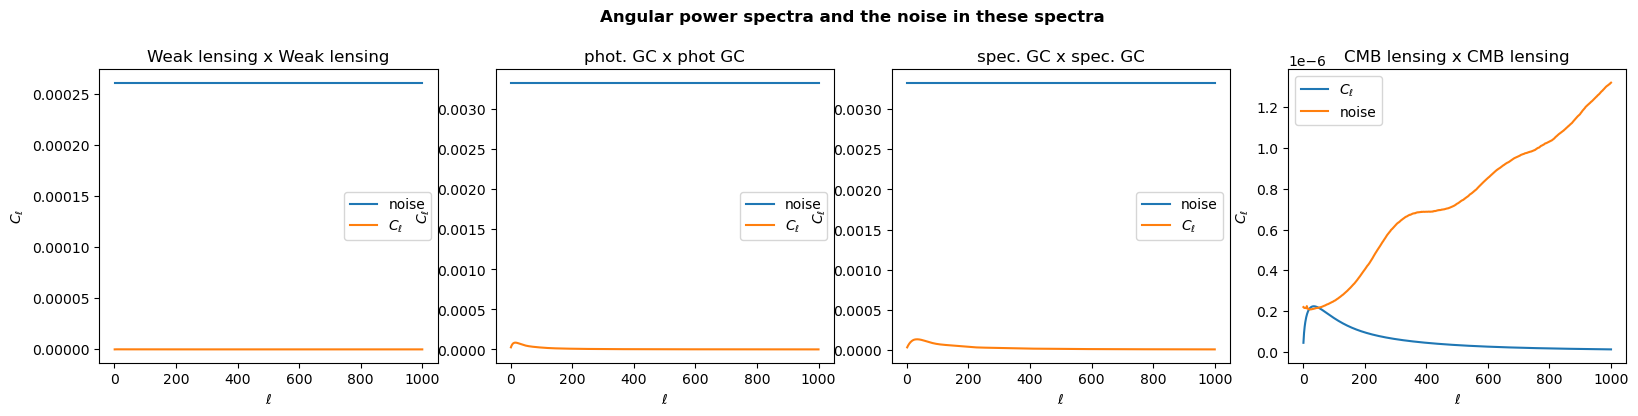

In [6]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
lcdm_auto_cmb = ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l, lcdm_cmb_l, l)
lcdm_cmb_wl = {i: ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l, lcdm_wl[i], l) for i in range(len(phot_tomo_bins))}
lcdm_cmb_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, lcdm_cmb_l, lcdm_photo_clus[i], l) for i in range(len(phot_tomo_bins))}
lcdm_cmb_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, lcdm_spec_clus[i], lcdm_cmb_l, l) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
lcdm_auto_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, lcdm_photo_clus[i], lcdm_photo_clus[i], l) for i in range(len(phot_tomo_bins))}
lcdm_auto_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, lcdm_spec_clus[i], lcdm_spec_clus[i], l) for i in range(len(spec_tomo_bins))}
lcdm_auto_wl = {i: ccl.angular_cl(lcdm_cosmo, lcdm_wl[i], lcdm_wl[i], l) for i in range(len(phot_tomo_bins))}

# The noise types accompanying the angular power spectra:
# Poisson error for galaxy clustering noise, point sources tracing homogeneous background field:
noise_gc = 1/n_bar * np.ones_like(l)

# Combined Poisson and Gaussian error for the point source distributions and Gaussian shear of galaxy shapes:
sigma_e = 0.28 # sigma_e_squared
noise_wl = (sigma_e**2)/n_bar * np.ones_like(l)

# For the CMB lensing noise we reference the method of Planck, resulting in:
noise_cmb_l = np.loadtxt('/home/xander/Masters-Project/notebooks/cmb_noise_Planck.txt')[:, 1]

#print(lcdm_auto_cmb)

# Now we check the implementation of the noise by splotting the noise together with the corresponding angular power spectrum:
fig, axes = plt.subplots(figsize=(16, 4), nrows=1, ncols=4)
plt.suptitle("Angular power spectra and the noise in these spectra\n", weight='bold')
plt.tight_layout()
#plt.subplots_adjust(hspace=0.5, wspace=0.5)

# For WL: 
# for j in range(len(phot_tomo_bins)):
#     axes[0].plot(l, lcdm_auto_wl[j], label=r'$C_{\ell}$' if j == 0 else "")
axes[0].plot(l, noise_wl, label='noise')
axes[0].plot(l, lcdm_auto_wl[5], label=r'$C_{\ell}$')
axes[0].set_title("\nWeak lensing x Weak lensing")
axes[0].legend()
axes[0].set_xlabel(r'$\ell$')
axes[0].set_ylabel(r'$C_{\ell}$')

# For Photometric GC:
# for k in range(len(phot_tomo_bins)):
#     axes[1].plot(l, lcdm_auto_gc_ph[k], label=r'$C_{\ell}$' if k == 0 else "")
axes[1].plot(l, noise_gc, label='noise')
axes[1].plot(l, lcdm_auto_gc_ph[0], label=r'$C_{\ell}$')
axes[1].set_title("\nphot. GC x phot GC")
axes[1].legend()
axes[1].set_xlabel(r'$\ell$')
axes[1].set_ylabel(r'$C_{\ell}$')

# For Spectroscopic GC:
# for m in range(len(spec_tomo_bins)):
#     axes[2].plot(l, lcdm_auto_gc_sp[m], label=r'$C_{\ell}$' if m == 0 else "")
axes[2].plot(l, noise_gc, label='noise')
axes[2].plot(l, lcdm_auto_gc_sp[0], label=r'$C_{\ell}$')
axes[2].set_title("\nspec. GC x spec. GC")
axes[2].legend()
axes[2].set_xlabel(r'$\ell$')
axes[2].set_ylabel(r'$C_{\ell}$')

# For CMB lensing: 
axes[3].plot(l, lcdm_auto_cmb, label=r'$C_{\ell}$')
axes[3].plot(l, noise_cmb_l[0:len(l)], label='noise')
axes[3].set_title("\nCMB lensing x CMB lensing")
axes[3].legend()
axes[3].set_xlabel(r'$\ell$')
axes[3].set_ylabel(r'$C_{\ell}$')

plt.show()

#### 3 massive neutrinos according to the NH:
Now we define the similar angular power spectra as we did above but for the 3 different neutrino cosmologies we defined earlier. Note that all neutrino cosmologies have the same total sum of neutrino masses: $\sum_{i} m_{\nu, i} = 0.12 eV$
Similarly to above, we now define the angular power spectra for the auto-correlated and cross-correlated tracers according to the cosmological model in which we have 3 massive neutrinos in a normal mass ordering

In [7]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
neutrino_auto_cmb = ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l, neutrino_cmb_l, l, l_limber=1120)
neutrino_cmb_wl = {i: ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l, neutrino_wl[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
neutrino_cmb_gc_ph = {i: ccl.angular_cl(neutrino_cosmo, neutrino_cmb_l, neutrino_photo_clus[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
neutrino_cmb_gc_sp = {i: ccl.angular_cl(neutrino_cosmo, neutrino_spec_clus[i], neutrino_cmb_l, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
neutrino_auto_gc_ph = {i: ccl.angular_cl(neutrino_cosmo, neutrino_photo_clus[i], neutrino_photo_clus[i], l) for i in range(len(phot_tomo_bins))}
neutrino_auto_gc_sp = {i: ccl.angular_cl(neutrino_cosmo, neutrino_spec_clus[i], neutrino_spec_clus[i], l) for i in range(len(spec_tomo_bins))}
neutrino_auto_wl = {i: ccl.angular_cl(neutrino_cosmo, neutrino_wl[i], neutrino_wl[i], l) for i in range(len(phot_tomo_bins))}

/home/xander/anaconda3/envs/new_cclenv/lib/python3.12/site-packages/pyccl/_nonlimber_FKEM.py:267: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(cells[-1] / cl_limber_nonlin[-1] - 1) < limber_max_error


#### Massless lightest neutrino; $m_{\nu, 1} = 0$

In [8]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
zero_mm_auto_cmb = ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l, zero_mm_cmb_l, l, l_limber=1120)
zero_mm_cmb_wl = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l, zero_mm_wl[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_gc_ph = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_cmb_l, zero_mm_photo_clus[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
zero_mm_cmb_gc_sp = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_spec_clus[i], zero_mm_cmb_l, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
zero_mm_auto_gc_ph = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_photo_clus[i], zero_mm_photo_clus[i], l) for i in range(len(phot_tomo_bins))}
zero_mm_auto_gc_sp = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_spec_clus[i], zero_mm_spec_clus[i], l) for i in range(len(spec_tomo_bins))}
zero_mm_auto_wl = {i: ccl.angular_cl(zero_mm_cosmo, zero_mm_wl[i], zero_mm_wl[i], l) for i in range(len(phot_tomo_bins))}

/home/xander/anaconda3/envs/new_cclenv/lib/python3.12/site-packages/pyccl/_nonlimber_FKEM.py:267: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(cells[-1] / cl_limber_nonlin[-1] - 1) < limber_max_error


#### One massive neutrino, 2 massless neutrino species

In [9]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
single_auto_cmb = ccl.angular_cl(single_nu_cosmo, single_cmb_l, single_cmb_l, l, l_limber=1120)
single_cmb_wl = {i: ccl.angular_cl(single_nu_cosmo, single_cmb_l, single_wl[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
single_cmb_gc_ph = {i: ccl.angular_cl(single_nu_cosmo, single_cmb_l, single_photo_clus[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
single_cmb_gc_sp = {i: ccl.angular_cl(single_nu_cosmo, single_spec_clus[i], single_cmb_l, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
single_auto_gc_ph = {i: ccl.angular_cl(single_nu_cosmo, single_photo_clus[i], single_photo_clus[i], l) for i in range(len(phot_tomo_bins))}
single_auto_gc_sp = {i: ccl.angular_cl(single_nu_cosmo, single_spec_clus[i], single_spec_clus[i], l) for i in range(len(spec_tomo_bins))}
single_auto_wl = {i: ccl.angular_cl(single_nu_cosmo, single_wl[i], single_wl[i], l) for i in range(len(phot_tomo_bins))}

/home/xander/anaconda3/envs/new_cclenv/lib/python3.12/site-packages/pyccl/_nonlimber_FKEM.py:267: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(cells[-1] / cl_limber_nonlin[-1] - 1) < limber_max_error


# Gaussian diagonal covariance

Here we figure out the Gaussian diagonal covariance and try to code this ourselves.
Look at
- Gaussian covariance for the $C_{l}$'s; (Dodelson, example 12.1; section 14.2)
- Different noise types
- Expressions for the different types of probes
- Wick's theorem

*Guess:*
1. Gaussian diagonal covariance describes an striclty auto-correlated parameter space. This is expressed in a diagonal covariance matrix, in which the variance in each parameter is Gaussian. The fact that the covariance matrix is diagonal means that any cross-correlations are disregarded. Thus, the parameters panning parameter space are *univariant* in auto-correlations and invariant in cross-correlations.

Look at sources:
- **[Section 2.5: Johnston, H., Chisari, N. E., Joudaki, S., Reischke, R., Stölzner, B., Loureiro, A., ... & Zhang, Y. H. (2024). 6x2pt: Forecasting gains from joint weak lensing and galaxy clustering analyses with spectroscopic-photometric galaxy cross-correlations. arXiv preprint arXiv:2409.17377](https://arxiv.org/abs/2409.17377)**
- **[Section 6: Rassat, A., Land, K., Lahav, O., & Abdalla, F. B. (2007). Monthly Notices of the Royal Astronomical Society, 377(3), 1085-1094.](https://watermark.silverchair.com/mnras0377-1085.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA5AwggOMBgkqhkiG9w0BBwagggN9MIIDeQIBADCCA3IGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMwbi2HLzrf3VtF_tBAgEQgIIDQ3YCxz_hwaRlcPM68Treuqkhb3c9-phZGoaHN6CJwoaIHwKG6TezsoaF7pLIpdR4BGIahf0e0uZXQht7x2Vuzb0QYYSj5MJOXPUnFZgk9GUSFKgOT0AiFScn_OZh7rK1i2glwLmMc66YstXfNrAflmxlSYRGEuBfILbYEtxLmicUwPVrmyLi_fJv96QZerxcesviCtEKA3LrI-ZgYlUIHOCrpu88SffoshsenjHBzt9rmJPetf7PrwgMDhL0mEKizmsaILsZgx0j-MWL8rEY9oz3xSCrSzcK6wXVVUfiKz2hfZp9xZkJvpwWIWB5czexmFKiDRIsZ2p4ReT2KvED0kXbK5ocHDyITsVIglihk0inPBTzRJ9mN4jVaNMaMJ_muLbUcMmMCMezaKdTGxWdeMk51g-DmN-t7ts_U-eMg0a5XDenD0CG-FDB9iR4jHK8uRRjZCWeq7W47QodiVoLdPdGd6jI9Clcv3Zc4MvCFs9mJlkWt6Z9I11d0djzMbKrCZf8CgdCU3arMxurJDnomLzQdjWG5deFHJHikFR464Qm0mx7F9jLq_eIqkZtbzaNGlY8_0DdhZ2-eTOkw-Y9v8PlDcjGzjC1GOBKk8uFNpCBOczk2TlITNRftSTFjo3JgF3m-SOTJbiJXWxCsDUGvuwqskCTH01ZaL_MhNtiwE_Sa1wsx9dxx5p0rCQ-aC8xwOzj4XhBzYphkziK-aPEloKsgzrd2GYwDkzaw-aV6l0X_jLIQLzd-ljQVirjuBHGyM30lRXRzoYnTu6227D9VcpVFzw_m816w2rFqC2wl1SP3ySGvndoKzIb1PAzTzlBMTWdJtfvHcjU7E6fdGfFlu6AjjFHz8jki1KT5POLTr-iEqYIcIOjjcSelTPFEybb1tO3UrLpTGHLJNE_osglSDELa7CUvIkbeVLvnuMgHbStuO9vO87U3M61v9z05BwuLPT_pJCGZgPoztHzhsvmv7vsbmr8drrJPMIcPty6EXPhMQqp8CfRQ8dxoDYUwCTjJeKc1147AuT24yXQ7CZ1SAnjem1byWyK7UI2WWTRRQxOdPHWHlQ77kTDcmq7IKNlUiLmmwVUBVtrkIEnlJiRWO3DJMY)**
- **[Later chapters of: Modern Cosmology; S. Dodelson, F. Schmidt](https://books.google.se/books?hl=nl&lr=&id=TpUmEQAAQBAJ&oi=fnd&pg=PP1&dq=modern+cosmology+dodelson&ots=BBo0fsLhcW&sig=KC-2ksaqhpjJvRv05wjpd2nS8Lg&redir_esc=y#v=onepage&q=modern%20cosmology%20dodelson&f=false)**


## Analytical expression:
We can write down the analytical expression for the Gaussian covariance through:
$Z = Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right]$, with:
$$Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right] = \frac{\delta_{\ell\ell'}^{K}}{f_{sky} (2\ell + 1)}\left(\hat{C}^{im}(\ell)\hat{C}^{jn}(\ell') + \hat{C}^{in}(\ell)\hat{C}^{jm}(\ell')\right)$$

where $4\pi f_{sky} = A_{survey}$ the fraction of the sky considered in the survey, $\delta_{\ell\ell'}^{K}$ is the K-dimensional Dirac delta which ensures that the multipole moments ($\ell$) are independent. In this expression we must note that $\hat{C}^{ij}(\ell)$ is the observed angular power spectrum. This means that it contains both the signal $\left(S^{ij}(\ell)\right)$ and the noise $\left(N^{ij}\right)$:
$$\hat{C}^{ij}(\ell) = S^{ij}(\ell) + N^{ij}\delta_{ij} $$

More specifically,
$$
\hat{C}^{ij} (\ell) = \begin{cases}
S^{ij} (\ell) + N_{source}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ source}.\\
S^{ij} (\ell) + N_{lens}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ lens}.\\
S^{ij} (\ell), & \text{else}
\end{cases}
$$

Where the noise differs for the case of galaxy clustering, weak lensing or CMB lensing. Note also that the noise only occurs for the auto-correlations (e.g. the diagonal of the covariance). 

Note: For CMB lensing, we make use of the noise as defined by Planck, stowed away in the file 'cmb_noise_Planck.txt' which we read in and use when needed.

In [10]:
"""
# Now we define a function that gives us the Gaussian coavariance based on the probe, the corresponding noise and surveysurface on the observed sky,
# a redshift distribution, bins and their binwidth.

def Gauss_cov(l, ang_power_spectrum, noise, f_sky, redshift_dist=None, bins=None, cross=False):
    # We calculate the Gaussia covariance based on the true-model tracer. The angular power spectrum that represents LCDM
    cov = np.zeros(shape=(len(ang_power_spectrum), len(ang_power_spectrum)))
    
    # We separate the cases of auto and cross-correlations:
    if cross == False:
        
        # Now we need to take into account the noise acompanying the angular power spectrum
        for i in range(len(l)):
            for j in range(len(l)):

                # For the diagonal elements, we compute auto correlations of the same probes, thus we includer the noise terms. Assume
                if i == j:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j] + noise[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * noise[j] + noise[i] * noise[j])
                
                # For the non-diagonal elements:
                else:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j])
    
    # Now for the cross-correlations:
    else:
        for i in range(len(l)):
            for j in range(len(l)):
                cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j])
    
    return cov

# tracer = np.array([100, 82, 56, 107, 89, 72, 97])
# noise = np.ones_like(tracer)
# l = np.linspace(10, 200, len(tracer))

# print("A", Gauss_cov(l, tracer, noise, 12, cross=True).shape, "matrix, which contains the following:\n", Gauss_cov(l, tracer, noise, 12, cross=True))

# plt.matshow(Gauss_cov(l, tracer, noise, 2, cross=True), None)
# plt.show()
"""

'\n# Now we define a function that gives us the Gaussian coavariance based on the probe, the corresponding noise and surveysurface on the observed sky,\n# a redshift distribution, bins and their binwidth.\n\ndef Gauss_cov(l, ang_power_spectrum, noise, f_sky, redshift_dist=None, bins=None, cross=False):\n    # We calculate the Gaussia covariance based on the true-model tracer. The angular power spectrum that represents LCDM\n    cov = np.zeros(shape=(len(ang_power_spectrum), len(ang_power_spectrum)))\n\n    # We separate the cases of auto and cross-correlations:\n    if cross == False:\n\n        # Now we need to take into account the noise acompanying the angular power spectrum\n        for i in range(len(l)):\n            for j in range(len(l)):\n\n                # For the diagonal elements, we compute auto correlations of the same probes, thus we includer the noise terms. Assume\n                if i == j:\n                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spec

In [11]:
# Start with a simplest case of the diagonal Gaussian covariance:

# The very implest case returns a vector that represents the daigonal of the Gaussian covariance, only consisting of auto-correlated bins
def calc_diag_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise_a, noise_b=None):
    """
    Note that not all angular power spectra are defined in the same amount of bins. TO account for this, we split the function in 3 different cases:
    The main problem will be the difference between the tracer of CMB lensing being defined in only 1 bin while the other tracers are defined in multiple bins, this we get the 3 cases:

    NOTE: We do not optimize for cross-correlations of the spec GC with other probes than CMB lensing
    """

    # auto CMB lensing x auto CMB lensing, all Cl's defined in 1 bin of length l:
    if len(IM) == len(JN) == len(IN) == len(JM) and len(IM) == len(l):
        pref = 1 / (f_sky * (2*l + 1))
        ez_diag_cov = pref * (((IM + noise_a) * (JN + noise_a)) + ((IN + noise_a) * (JM + noise_a)))

    # For covariance of auto CMB lensing with cross-correlated CMB lensing Cl, assume:
    elif len(IM) == len(JM) == len(l) and len(JN) == len(IN) < len(l): # Assuming we have less tomorgaphic bins than elements in the array of te multipoles
        ez_diag_cov = {}
        pref = 1 / (f_sky * (2 * l + 1))
        for key in JN.keys():
            ez_diag_cov[key] = pref * (((IM + noise_a) * JN[key]) + ((IN[key]) * (JM + noise_a)))

    # Covariance of two of the same cross-correlated angular power spectra of CMB lensing with any of the other probes, NOTE: let noise_a be the CMB lensing noise, noise_bis the noise of the other probe
    elif len(IM) == len(l) and len(JN) == len(IN) == len(JM) < len(l):
        ez_diag_cov = {}
        pref = 1 / (f_sky * (2 * l + 1))
        for key in JN.keys():
            # for el in JN.keys():
            #     if key == el:
            ez_diag_cov[key] = pref * (((IM + noise_a) * (JN[key] +  noise_b)) + ((IN[key]) * (JM[key])))
                    # ez_diag_cov[key] = pref * (((IM + noise_a) * (JN[el] +  noise_b)) + ((IN[key]) * (JM[el])))

                
    return ez_diag_cov

# def ez_calc_diag_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise_a, noise_b):
#     pref = 1 / (f_sky * (2 * l + 1))
#     return (pref * (IM * JN + (IN + noise_a) * (JM + noise_b)))

"""
# We look at the auto correlation of a single variation of the angularpower spectrum
def simple_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise=None):
    
    # Set the noise to 0 if there is no noise specified:
    if noise is None:
        noise = np.zeros_like(l)
    
    # Initiate the covariance matrix:
    simple_cov = np.zeros(shape=(len(l), len(l)))
    
    # Now we calculate the covariance of the elements:
    for i in range(len(l)): # NOTE: Should the range not be over the bins?
        pref = 1/(f_sky * (2*l[i] + 1))
        for j in range(len(l)):
            if i == j:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]) + (noise[i] * noise[j]) + ((IM[i] + IN[i]) * noise[j]) + ((JN[j] + JM[j]) * noise[i]))
            else:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]))

    return simple_cov
    """

'\n# We look at the auto correlation of a single variation of the angularpower spectrum\ndef simple_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise=None):\n\n    # Set the noise to 0 if there is no noise specified:\n    if noise is None:\n        noise = np.zeros_like(l)\n\n    # Initiate the covariance matrix:\n    simple_cov = np.zeros(shape=(len(l), len(l)))\n\n    # Now we calculate the covariance of the elements:\n    for i in range(len(l)): # NOTE: Should the range not be over the bins?\n        pref = 1/(f_sky * (2*l[i] + 1))\n        for j in range(len(l)):\n            if i == j:\n                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]) + (noise[i] * noise[j]) + ((IM[i] + IN[i]) * noise[j]) + ((JN[j] + JM[j]) * noise[i]))\n            else:\n                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]))\n\n    return simple_cov\n    '

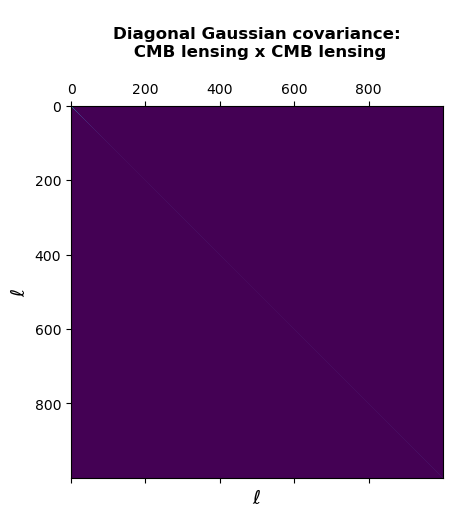

<class 'numpy.ndarray'> <class 'dict'> <class 'dict'>


In [12]:
# Now we want to determine the Gaussian covariance:
# cov_cmbl_wl = simple_Gaussian_cov(l, lcdm_cmb_wl[0], lcdm_cmb_wl[0], lcdm_auto_cmb[0], lcdm_auto_wl[0], 0.00012, noise=noise_wl)
# cov_cmbl_wl_next = simple_Gaussian_cov(l, lcdm_cmb_wl[5], lcdm_cmb_wl[5], lcdm_auto_cmb[5], lcdm_auto_wl[5], 0.00012, noise=noise_wl)

# Determine the relevant auto-correlated angular power spectra
cov_auto_cmb = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_auto_cmb, lcdm_auto_cmb, lcdm_auto_cmb, 0.36, noise_cmb_l[0:len(l)], noise_cmb_l[0:len(l)])

# Try and visualize the diagonal:
mat_ez_cov_auto_cmb = np.zeros([len(l), len(l)])
for i in range(len(l)):
    for j in range(len(l)):
        if i == j:
            mat_ez_cov_auto_cmb[i, j] = cov_auto_cmb[i]

# plt.matshow(cov_cmbl_wl)
# plt.matshow(cov_cmbl_wl_next)
plt.matshow(mat_ez_cov_auto_cmb)
plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r"$\ell$", fontsize=14)
# plt.xticks([0, 10, 20, 30, 40, 49.5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
# plt.yticks([0, 10, 20, 30, 40, 49.5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
plt.title("\nDiagonal Gaussian covariance:\n CMB lensing x CMB lensing\n", weight='bold')
plt.show()

# The other covariances we need:
cov_cross_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_auto_wl, lcdm_cmb_wl, lcdm_cmb_wl, 0.36, noise_cmb_l[0:len(l)], noise_wl)
cov_auto_cmb_wl = calc_diag_Gaussian_cov(l, lcdm_auto_cmb, lcdm_cmb_wl, lcdm_cmb_wl, lcdm_auto_cmb, 0.36, noise_cmb_l[0:len(l)])

print(type(cov_auto_cmb), type(cov_cross_cmb_wl), type(cov_auto_cmb_wl))


# Multipoles binning:
Now we bin both the angular power spectra and the Gaussian covariance. As briefly touched upon above, there are two reasons for doing this. The first one is more obvious than the second, namely to reduce the computational cost. The second reason is related to the observations of the LLS. In practice, the mask applied to the observations induces some weak but present correlations between all multipoles. We really observe:
$$C_{l} = \sum_{l^{'}} M_{l, l^{'}} \hat{C_{l^{'}}}$$

with $M_{l, l^{'}}$ the mixing matrix.
This causes the correlations between  multipoles to look like a distorted distribution with a finite peak width. From this distribution we obtain the binwidth $\Delta \ell$ as the full width half mean of the distribution for optimized binning of the multipoles

## Binning the angular power spectra:
This is effectively done by a weigted avarage of the angular power spectra IF the binning is done linearly. For the spectroscopic anguler power spectrum, we want to but the linearly. The sectroscopic angular power spectrum contains some oscillations for multipoles right after the peak in the spectrum. If we would bin this logarithmicaly, we would mis some of the features and losse out on accuracy and information.
For the other anfular power spectra, we can bin logarithmicaly since these spectra are seemingly featureless beyond their large scale shape and thus will not cause any problems when binning logarithmicaly.

**- The logarithmic case should be obtained by a geometric mean:
    geom mean is approx. np.exp(np.mean(log10(elements in the logarithmic bin)))**

[ 1.12946271  1.4219093   1.79007775  2.25357437  2.83708205  3.57167468
  4.49647202  5.66072289  7.1264279   8.97164117 11.29462706 14.21909302
 17.90077754 22.53574373 28.37082046 35.71674683 44.96472021 56.60722891
 71.26427896] 19


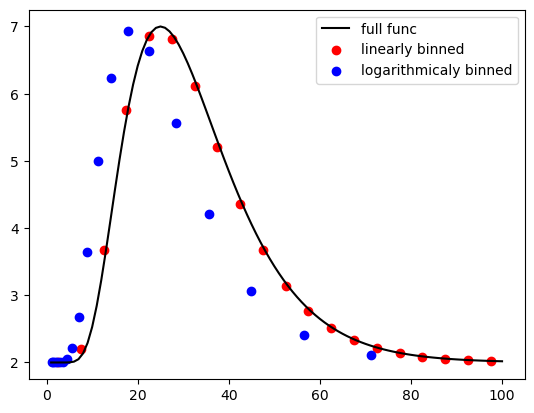

In [ ]:
# Define a function that bins the angular powerspectra in "multipole-space"
def bin_angular_cl(Cl, lmin, lmax, N_l, type="linear"):

    # Define a list to put the binned angular power spectrum in; also, later on we will need the degrees of freedom of the angular power spectra(number of bins):
    binned_Cl = []
    l_binned = []
    dof = 0

    # We start by defining a counter to keep track of the binsize and the sum of elements within the bin
    sub_bin_l = 1 # number of l's in the bin
    temp_sum = 0 # sum of elements of Cl within a bin

    # First deal with the linear binning:
    if type == "linear":
        # Define the binsize and an empty list to store the binned multipoles in
        binsize = (lmax - lmin + 1)/N_l

        for i in range(len(Cl + binsize)):
            # Within the bin, we sum the entries:
            if sub_bin_l < binsize:
                temp_sum += Cl[i]
                sub_bin_l += 1
            
            # When we hit the binsize, we determine the average, append it and increase the degrees of freedom:
            elif sub_bin_l == binsize:
                # Determine and log the desired quantities:
                temp_sum += Cl[i]
                binned_Cl.append(temp_sum/sub_bin_l)
                if dof == 0:
                    l_binned.append(sub_bin_l/2)
                else:
                    l_binned.append(sub_bin_l + l_binned[dof - 1])
                dof +=1

                # Reset all the bin-variables 
                temp_sum = 0
                sub_bin_l = 1

    # Now for the logarithmically binned angular power spectra:
    elif type == "log":
        # Define the logarithmically binned multipoles:
        loglike_l = np.logspace(np.log10(lmin), np.log10(lmax), N_l + 1)

        for j in range(len(Cl)):

            # The binsize changes in a logspace so we define the changing binsize:
            binsize_j = loglike_l[dof + 1] - loglike_l[dof]
            
            # Within the bin, we sum the entries:
            if sub_bin_l < np.round(binsize_j, 1): #loglike_l[dof]:
                temp_sum += np.log(Cl[j])
                sub_bin_l += 1
            
            # When we hit the binsize, we determine the average, append it and increase the degrees of freedom:
            elif sub_bin_l >= np.round(binsize_j, 1): #loglike_l[dof]:
                # Determine and log the desired quantities:
                temp_sum += np.log(Cl[j])
                binned_Cl.append(np.exp(temp_sum/sub_bin_l))
                l_binned.append((binsize_j)/2 + loglike_l[dof])

                dof +=1

                # Reset all the bin-variables 
                temp_sum = 0
                sub_bin_l = 1

    return np.array(l_binned), np.array(binned_Cl), dof

# For a test function, to see the behavior of the binning of the angular power spectra:
x = np.linspace(1, 100, 100)
func = 5 * np.exp((-1 * (x - 25)**2)/(10*x)) + 2

# Call the function
lin_func = bin_angular_cl(func, np.min(x), np.max(x), 20)
log_func = bin_angular_cl(func, np.min(x), np.max(x), 20, type="log")

# print(lin_func[0], lin_func[1])
# print(log_func[0], log_func[1])
print(log_func[0], len(log_func[1]))

plt.figure()
plt.plot(x, func, color='k', label='full func')
plt.scatter(lin_func[0], lin_func[1], color='r', label="linearly binned")
plt.scatter(log_func[0], log_func[1], color='b', label="logarithmicaly binned")
plt.legend()
plt.show()


1
0
0
1
1
0
2
1
1
2
3
3
4
6
6
8
11
13
16
20
1
0
0
1
1
0
2
1
1
2
3
3
4
6
6
8
11
13
16
20


/tmp/ipykernel_2095/59868310.py:53: RuntimeWarning: invalid value encountered in scalar divide
  CL_in_bin.append( 10**( np.sum( np.log10( CL[tomo_bin][current_log_bin] ) ) / len(current_log_bin[current_log_bin == True]) ) )


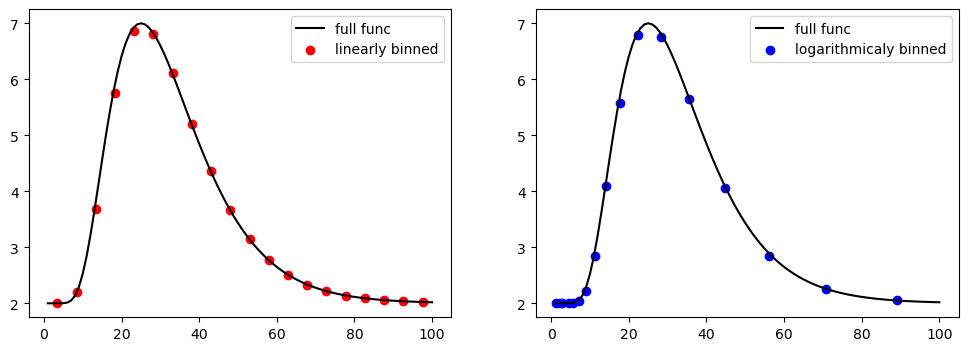

In [ ]:
# Here we (re)define the binning function to cover both the linear and logarithmic binning:

def bin_multipoles_CL(l, CL, N_l, type="linear"): # For logarithmic binning, take type='log'
    """
    l; array of multipoles
    CL; a dictionary containing arrays of the angular power spectrum in each tomographic bin
        defined off of l such that they are of similar length
    N_l; int; desired number of multipole bins
    type; linear binning is default, change to typ='log' for logarithmic binning
    
    returns:
    l_binned; array of binned multipoles
    binned_Cl; array of the binned agular power spectrum
    dof; int, the number of degreed of freedom
    """

    # Define the empty dictionary in which we can put the binned CL'segment
    binned_Cl = {}

    # Note: Because we would wish to return the dof for each angular powerspectrum including all tomographic bins; such that we must take CL to be the full "tomographic dictionary"
    dof = 0 # The number of degrees of freedom 

    # For linear binning
    if type == "linear":
        # We need the 'N_l + 1' to ensure that we have N_l bins instead of N_l -1 bins following from N_l (data)points
        linear_l = np.linspace(np.min(l), np.max(l), N_l + 1)
        l_binned = 0.5 * (linear_l[:-1] + linear_l[1:])
        
        # Go through all tomographic bins of the angular power spectrum:
        for tomo_bin in range(len(CL)):
            CL_in_bin = []
            for i in range(len(linear_l) - 1):
                current_lin_bin = (l >= linear_l[i]) &  (l < linear_l[i + 1])
                within_bin = CL[tomo_bin][current_lin_bin]
                CL_in_bin.append(np.mean(within_bin))
                # CL_in_bin.append(np.mean(CL[tomo_bin][current_lin_bin]))
                dof += 1
            
            # Store the binned CL's in the empty dictionary defined above: 
            binned_Cl[tomo_bin] = np.array(CL_in_bin)

    # For the case that we want logarithmic binning:
    elif type == "log":
        loglike_l = np.logspace(np.log10(np.min(l[l > 0])), np.log10(np.max(l)), N_l + 1)
        l_binned = np.sqrt(loglike_l[:-1] * loglike_l[1:])

        # For the tomorgaphic bins of the angular power spectrum:
        for tomo_bin in range(len(CL)):
            CL_in_bin = []
            for j in range(len(loglike_l) - 1):
                current_log_bin = (l >= loglike_l[j]) & (l < loglike_l[j + 1])
                CL_in_bin.append( 10**( np.sum( np.log10( CL[tomo_bin][current_log_bin] ) ) / len(current_log_bin[current_log_bin == True]) ) )
                dof += 1
            
            # Store the binned CL's in the empty dictionary defined above:
            binned_Cl[tomo_bin] = np.array(CL_in_bin)


    return l_binned, binned_Cl, dof 

# For a test function, to see the behavior of the binning of the angular power spectra:
x = np.linspace(1, 100, 100)
func = 5 * np.exp((-1 * (x - 25)**2)/(10*x)) + 2
func2 = np.exp((-1 * (x - 25)**2)/(10*x)) + 2

# COmbine test functions in a test dictionary
funcs = {0: func, 1: func2}

# Call the function
lin_func = bin_multipoles_CL(x, funcs, 20)
log_func = bin_multipoles_CL(x, funcs, 20, type="log")

# print(lin_func[0], lin_func[1])
# print(log_func[0], log_func[1])
# print(log_func[0], log_func[1], log_func[2])

# Plot the results of the binning of the function for logarithmic and linear binning:
fig, axes = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

axes[0].plot(x, func, color='k', label='full func')
axes[0].scatter(lin_func[0], lin_func[1][0], color='r', label="linearly binned")
axes[0].legend()

axes[1].plot(x, func, color='k', label='full func')
axes[1].scatter(log_func[0], log_func[1][0], color='b', label="logarithmicaly binned")
axes[1].legend()

plt.show()

## Binning the Gaussian covariance:
The binning of the Gaussian covariance is different than the angular power spectra:


In [15]:
def bin_cov_dict(
    cov_dict,
    ell,
    n_ell_bins=20,
    linear_binning=False,
    fsky=0.35,
    remove_prefactor=True
):
    """
    Bin a dictionary of diagonal Gaussian covariances over ell,
    optionally removing the (2ℓ+1)/fsky prefactor if present.

    Parameters
    ----------
    cov_dict : dict
        Dictionary of diagonal Gaussian covariances (variances per ell),
        keyed by tomographic bin (or other index).
    ell : array_like
        Multipole array (same length as each covariance array).
    n_ell_bins : int
        Number of ell bins.
    linear_binning : bool
        Whether to use linear binning (otherwise uses log).
    fsky : float
        Sky fraction used in covariance prefactor.
    remove_prefactor : bool
        If True, divide out the (2ℓ+1)/fsky factor before binning.

    Returns
    -------
    binned_cov : dict
        Dictionary of binned variances of the mean per bin.
    bin_centers : array
        Centers of ell bins (arithmetic or geometric mean).
    counts : dict
        Number of ℓ values per bin for each key.
    """
    ell = np.asarray(ell)
    two_ell_plus_one = ell * (ell + 1)
    #prefactor = (two_ell_plus_one * fsky)

    if linear_binning:
        bin_edges = np.linspace(ell.min(), ell.max(), n_ell_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    else:
        bin_edges = np.logspace(np.log10(ell[ell > 0].min()), np.log10(ell.max()), n_ell_bins + 1)
        bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])

    binned_cov = {}
    counts = {}

    for key, cov in cov_dict.items():
        cov = np.asarray(cov)
        if remove_prefactor:
            cov_noprefactor = cov * (fsky*two_ell_plus_one)
        else:
            cov_noprefactor = np.asarray(cov)

        binned = []
        bin_counts = []

        for i in range(n_ell_bins):
            mask = (ell >= bin_edges[i]) & (ell < bin_edges[i + 1])
            N = np.sum(mask)
            bin_counts.append(N)

            if N == 0:
                binned.append(np.nan)
            else:
                weighted_sum = np.sum(cov_noprefactor[mask] / two_ell_plus_one[mask])
                binned_covariance = weighted_sum / (fsky * N * N)
                binned.append(binned_covariance)

        binned_cov[key] = np.array(binned)
        counts[key] = np.array(bin_counts)

    return binned_cov, bin_centers, counts

# $\Delta \chi^{2}$
Now we can determine the value of $\Delta \chi ^{2}$ in each bin; to do so we calculate the following:$$\Delta \chi ^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos and $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos. Note: We define the Gaussian covariance using the angular power spectra of the $\Lambda CDM$ cosmologies and use these to find the quantity of $\Delta \chi^{2}$


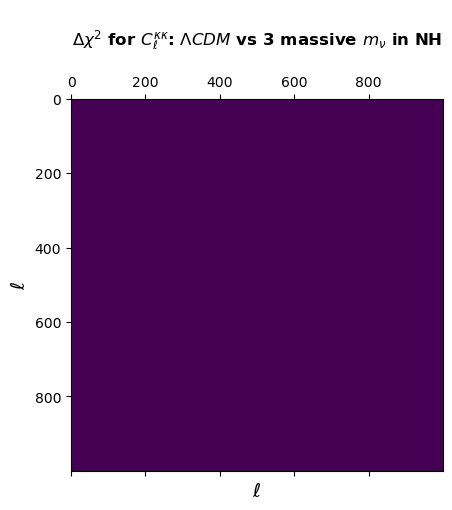

In [16]:
# Look at the 
def calc_del_chi_squared(Cl_1, Cl_2, cov):
    
    # Depending on the angular power spectra, we must consider the covariance to be a dictionary of arrays or an array:
    if type(cov) == 'dict':
        
        # Define the array in which we store the Delta chi squared for each bin:
        del_chi = np.zeros([len(Cl_1), len(Cl_1)]).astype(float)
        for i in range(len(Cl_1)):

            # Determine the Cl_1 - Cl_2 in the current bin we loop within:
            diff_i = Cl_1[i] - Cl_2[i]
            product_i = (1/cov[i]) * diff_i

            for j in range(len(cov[i])):

                # To determine the value of Delta chi squared, we perform a dot-product between the transposed difference and the product of the inverse of the
                # diagonal of the Gaussian covariance and the difference itself. NOTE: since we consider the simple case of a diagonal Gaussian covariance, we
                # can take 1/Cov as the inverse:
                del_chi[i, i] += diff_i[j] * product_i[i]#((1 / cov[j]) * diff_i[j])
        
    # Assuming that the only other possibiity is: type(cov) = 'array'
    else:
        del_chi = np.zeros([len(cov), len(cov)]).astype(float)
        diff = Cl_1 - Cl_2
        for k in range(len(cov)):
            product_k = (1 / cov) * diff
            del_chi[k, k] += diff[k] * product_k[k]

    return del_chi

del_chi_auto_cmb_neutrinos = calc_del_chi_squared(lcdm_auto_cmb, neutrino_auto_cmb, cov_auto_cmb)

plt.matshow(del_chi_auto_cmb_neutrinos)
plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r"$\ell$", fontsize=14)
# plt.xticks([0, 1, 2, 3, 4, 5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
# plt.yticks([0, 1, 2, 3, 4, 5], ["bin 1", "bin 2", "bin 3", "bin 4", "bin 5", "bin 6"])
plt.title("\n" + r"$\Delta \chi^{2}$ for $C_{\ell}^{\kappa\kappa}$: $\Lambda CDM$ vs 3 massive $m_{\nu}$ in NH" + "\n", weight='bold')
plt.show()


## Extend the results
There are two approaches in which we can extend these results. First of all, to keep it simple and straigtforward, we can extend the result by using the same definition of the daigonal Gaussian covariance and correlate other probes to build up the full covariance matrix consisting of diagonal suubmatrices that only auto-correlate the bins. Alternatively we can rewrite the definition of the Gaussian covariance with the goal of generalizing the covariance matrix by including cross-correlated bins.

In [17]:
# Now we determine the del chi squared for the other models

# P-value
To be able to (loosly) identify the effect of the neutrino masses on the angular power spectra, we determine the p-value based on the $\Delta \chi^{2}$ acquired before.

We start by determining the value chi squared from $\Delta \chi^{2}$ and the number of degrees of freedom.
This we can pass on into the calculation of the p-value.

- **Use scipy to calc chi squared;  
for cdf -- del chi 2 - dof**
- **depending on the use of pdf or cdf in the previous step, determine the p-value;   
For the cdf it should be 1 - chi2**

# Results:

For the model that considers 3 massive neutrinos compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |

For the model that considers the loghtest neutrino to be massless, accompanied by 2 massive neutrinos of equal mass compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |

For the model that considers 2 massless neutrinos together with 1 massive neutrino compared to the $\Lambda CDM$ model:

| Probe 1 | Probe 2 | $\ell_{range}$ | $N_{\Delta \ell}$  | $\ell$-type | $\Delta \chi^{2}$ | p-value |
| -------- | ------- | ------- | ------- | ------- | ------- | ------- |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |